# Preparation

In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from trafficSimulator import *

def parallel_line(current_coordinates, distance):
    x1, y1 = current_coordinates[0]
    x2, y2 = current_coordinates[1]
    k = (y1-y2)/(x1-x2)
    b = y1 - k*x1
    
    cross_x = -b/k
    hypo = math.sqrt(b**2+cross_x**2)
    
    if k>0:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))

        new_coord_2 = ((x2-distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
        
    else:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
    
        new_coord_2 = ((x2-distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))
    
    return new_coord_1, new_coord_2

pygame 2.0.1 (SDL 2.0.14, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Simulation setup

## Simulation params setup

In [2]:
all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]

v_max = 15
s0 = 7.5
T = 1.5
b_max = 3
a_max = 2

vehicle_specs = {'v_max': v_max, # Desired speed
                 's0': s0, # Safe bumper-to-bumper distance
                 'T': T, # Time gap
                 'b_max': b_max, # Deceleartion
                 'a_max': a_max, # Acceleration
                }

vehicle_rate = 45
fast_track_factor, slow_track_factor = 1, 0.6
stop_distance = 50
wait_time = 2
vehicle_limit = 50

df = pd.DataFrame(columns=['Vehicle_label', 'Road_order', 
                           'Total_time', 'Leading_vehicles',
                           'Stopped_time', 'Stop_while_front'])

vehicle_preferences = dict(zip(range(vehicle_limit), 
                               [[0.25, 0.25, 0.25, 0.25]]*vehicle_limit))

## Topology setup

In [3]:
left, right = -100*math.sqrt(3), 100*math.sqrt(3)
bottom, top = -100, 100

left_bottom_outbound = ((left+2, 4), (-5, top-2),
                        slow_track_factor, stop_distance, wait_time)
bottom_right_outbound = ((5, top-2), (right-2, 4),
                         fast_track_factor, stop_distance, wait_time)

left_top_outbound = ((left+2, -4), (-5, bottom+2),
                     fast_track_factor, stop_distance, wait_time)
top_right_outbound = ((5, bottom+2), (right-2, -4),
                      slow_track_factor, stop_distance, wait_time)

bottom_left_inbound = parallel_line(current_coordinates=left_bottom_outbound, 
                                    distance=2.5)[0]
right_bottom_inbound = parallel_line(current_coordinates=bottom_right_outbound, 
                                     distance=2.5)[1]

top_left_inbound = parallel_line(current_coordinates=left_top_outbound, 
                                 distance=2.5)[0]
right_top_inbound = parallel_line(current_coordinates=top_right_outbound, 
                                  distance=2.5)[1]

## For the connections of the topology, we can either represent with concrete lines
## or just as a dot (as shown below). Either case, the vehicles will not actually go 
## pass these routes; they are more for demonstration purposes

connection_top_bottom = ((-1.25, bottom+2), (-1.25, top-2))
connection_bottom_top = ((1.25, top-2), (1.25, bottom+2))

# Or just show a dot:

# connection_top_bottom = ((-1.25, -2), (-1.25, 2))
# connection_bottom_top = ((1.25, 2), (1.25, -2))

## Utility params setup

In [4]:
# Smaller delta encourages more exploration
delta = 0.1
# Penalty proportion for delay caused
alpha = 0

gamma_mean, gamma_var = 1, 0.5
eta_mean, eta_var = 1, 0.5

# Create and run simulation

In [5]:
 def run_simulation(round_number, all_routes, vehicle_limit, df, vehicle_preferences,
                    vehicle_rate, vehicle_specs):
    global left_bottom_outbound
    global bottom_right_outbound
    global left_top_outbound
    global top_right_outbound
    global connection_top_bottom
    global connection_bottom_top
    global bottom_left_inbound
    global right_bottom_inbound
    global top_left_inbound
    global right_top_inbound
    
    records = df.copy()
    sim = Simulation({
        'round_number': round_number,
        'all_routes': all_routes, # All possible (and reasonable) routes
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'records': records, # Table that will capture the needed vehicle-related info
        'vehicle_preferences': vehicle_preferences
        # A dictionary that stores the vehicles' labels as keys and their list of probabilities
        # of choosing each possible route as values
        # For the initial few rounds all vehicles choose all routes with equal weights.
        # For more complicated topologies some other algorithms will be needed as all possible
        # routes are not as explicit as in here.
        })

    sim.create_roads([
        ## Key routes
        left_bottom_outbound, # Road #0
        bottom_right_outbound, # Road #1

        left_top_outbound, # Road #2
        top_right_outbound, # Road #3

        connection_top_bottom, # Road #4
        connection_bottom_top, # Road #5

        bottom_left_inbound, # Road #6
        right_bottom_inbound, # Road #7

        top_left_inbound, # Road #8
        right_top_inbound, # Road #9

        ## Curved corners
        # Note: in the simulation, the vehicles will not actually go pass these
        # routes; they are more for aesthetic purposes

        # Outbound corners
        *curve_road(left_bottom_outbound[1], 
                    (bottom_right_outbound[0][0], bottom_right_outbound[0][1]+0.01), 
                    (0, top), 16), # Outbound bottom corner; Roads #10-#25

        *curve_road(left_top_outbound[1], 
                    (top_right_outbound[0][0], top_right_outbound[0][1]+0.01), 
                    (0, bottom), 16), # Outbound top corner; Roads #26-#41

        *curve_road(left_bottom_outbound[0], 
                    (left_top_outbound[0][0]+0.01, left_top_outbound[0][1]), 
                    (left, 0), 16), # Outbound left corner; Roads #42-#57

        *curve_road(bottom_right_outbound[1], 
                    (top_right_outbound[1][0]+0.01, top_right_outbound[1][1]), 
                    (right, 0), 16), # Outbound right corner; Roads #58-#73

        # Inbound corners
        *curve_road(right_bottom_inbound[1], 
                    (bottom_left_inbound[0][0], bottom_left_inbound[0][1]+0.01), 
                    (0, top), 16), # Inbound bottom corner; Roads #74-#89

        *curve_road(right_top_inbound[1], 
                    (top_left_inbound[0][0], top_left_inbound[0][1]+0.01), 
                    (0, bottom), 16), # Inbound top corner; Roads #90-#105

        *curve_road(bottom_left_inbound[1], 
                    (top_left_inbound[1][0]+0.01, top_left_inbound[1][1]), 
                    (left+2.5, 0), 16), # Inbound left corner; Roads #106-#121

        *curve_road(right_bottom_inbound[0], 
                    (right_top_inbound[0][0]+0.01, right_top_inbound[0][1]), 
                    (right-2.5, 0), 16), # Inbound right corner; Roads #122-#137
    ])


    sim.create_gen({
        'vehicle_rate': vehicle_rate, # Rate of generating new vehicles
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'vehicles': vehicle_specs
        })


    # Start simulation
    win = Window(sim)
    win.zoom = 3
    new_records = win.run(steps_per_update=5)
    
    return new_records

In [9]:
%%time
# Run the 1st round
record_df1 = run_simulation(1, all_routes, vehicle_limit, df, vehicle_preferences,
                             vehicle_rate, vehicle_specs)

Wall time: 5min 28s


# Simulation Analysis Setup after 1st round

In [10]:
record_df1['Round_number'] = 1

record_df = record_df1.copy()
record_df.head(10)

,Vehicle_label,Road_order,Total_time,Leading_vehicles,Stopped_time,Stop_while_front,Round_number
0,37,"[2, 1]",25.3,"[-999, -999]","[0, 0]","[0, 0]",1
1,1,"[2, 3]",37.42,"[37, -999]","[0, 0]","[0, 0]",1
2,42,"[2, 1]",33.06,"[1, 37]","[0, 0]","[0, 0]",1
3,2,"[2, 1]",41.56,"[42, 0]","[1.4000000000000008, 0.06]","[1.4000000000000008, 0]",1
4,38,"[0, 3]",39.38,"[-999, 1]","[0, 0]","[0, 0]",1
5,0,"[0, 1]",34.26,"[38, 42]","[0, 0]","[0, 0]",1
6,19,"[2, 3]",51.62,"[2, 13]","[1.4800000000000009, 0.5000000000000001]","[1.4800000000000009, 0]",1
7,10,"[2, 1]",47.88,"[19, 2]","[0, 0]","[0, 0]",1
8,13,"[0, 3]",43.5,"[0, 38]","[0, 0]","[0, 0]",1
9,3,"[0, 3]",55.96,"[13, 19]","[2.2000000000000015, 0]","[2.2000000000000015, 0]",1


## Set up dataframe

In [ ]:
utility_df = pd.DataFrame(columns=['Vehicle_label', 'Utilities', 'Probabilities'])

utility_df['Vehicle_label'] = list(range(len(record_df.Vehicle_label.unique())))
utility_df['Routes_taken'] = [[]] * len(utility_df)
utility_df['Utilities'] = [[0] * len(all_routes)] * len(utility_df)
utility_df['Probabilities'] = [[0] * len(all_routes)] * len(utility_df)

In [ ]:
etas = []
gammas = []

for i in range(len(utility_df)):
    eta = np.random.normal(eta_mean, eta_var, 1)[0]
    while eta < 0:
        eta = np.random.normal(eta_mean, eta_var, 1)[0]
    etas.append(eta)
    
for i in range(len(utility_df)):
    gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    while gamma < 0:
        gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    gammas.append(gamma)

utility_df['Gamma'] = gammas
utility_df['Eta'] = etas

utility_df = utility_df.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)            
utility_df.head(5)

## Set up functions

In [ ]:
def utility_summary(record_df):
    utility_tmp = record_df[['Vehicle_label', 'Road_order', 'Total_time']]

    utility_tmp['Caused_delay'] = 0.0
    utility_tmp.Total_time = pd.to_numeric(utility_tmp.Total_time)

    utility_tmp = utility_tmp.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)

    for idx, row in record_df.iterrows():
        current_l = row['Vehicle_label']
        stop_times = row['Stopped_time']
        lead_v = row['Leading_vehicles']
        route = row['Road_order']

        for i in range(len(stop_times)):
            if stop_times[i] > 0:
                utility_tmp.at[lead_v[i], 'Caused_delay'] += stop_times[i]

        for r in all_routes:
            if route == r:
                utility_tmp.at[idx, 'Road_order'] = all_routes.index(r)

    utility_tmp['Count'] = 1
    utility_tmp = pd.pivot_table(utility_tmp, 
                   index=['Vehicle_label', 'Road_order'], 
                   values=['Total_time', 'Caused_delay', 'Count'], 
                   aggfunc={'Total_time': np.mean,
                            'Caused_delay': np.mean,
                            'Count': 'count'}).reset_index(drop=False)
    return utility_tmp

In [ ]:
def compute_utility(explored_times,
                    time=0, 
                    caused_delay=0, 
                    alpha=0, 
                    gamma=0, 
                    eta=0, 
                    delta=0.1):
    if explored_times > 0:
        # Interpolation between time and money
        u_time = -np.log(time)
        u_penalty = -np.log(caused_delay*alpha)

        if eta == 1:
            u_total = gamma * u_time + u_penalty
        else:
            u_total = (np.exp(1-eta)-1) / (1-eta)
    else:
        u_total = 0
        
    u_total += np.sqrt(2*np.log(1/delta)/explored_times)
    return u_total

def compute_probability(utility_list):
    prob_list = [np.exp(u) for u in utility_list]
    return [p/sum(prob_list) for p in prob_list]

In [ ]:
def update_utility_df(record_df, df, utility_tmp, round_number=1):
    global all_routes
    utility_df = df.copy()
    
    for idx, row in utility_df.iterrows():
        i = row['Vehicle_label']
        utility_l = row['Utilities'][:]
        prob_l = row['Probabilities'][:]
        routes = row['Routes_taken'][:]
        gamma = row['Gamma']
        eta = row['Eta']

        for j in range(len(all_routes)):
            record = utility_tmp.loc[(utility_tmp.Vehicle_label==i) & (utility_tmp.Road_order==j)]
            if len(record) == 0:
                utility_l[j] = compute_utility(explored_times=0.5, delta=delta) # Exploration time is not integer here
                                                                                # because utility will be infinite if
                                                                                # it is 0 and it will cause problems in prob
                                                                                # calculation
            else:
                utility_l[j] = compute_utility(explored_times=record['Count'].values[0], 
                                               time=record['Total_time'].values[0], 
                                               caused_delay=record['Caused_delay'].values[0], 
                                               alpha=alpha, 
                                               gamma=gamma, 
                                               eta=eta, 
                                               delta=delta)

        prob_l = compute_probability(utility_l)
        new_route_list = record_df.loc[(record_df.Vehicle_label==i) &
                                       (record_df.Round_number==round_number)]['Road_order'].values[0]
#         display(record_df.loc[(record_df.Vehicle_label==i) &
#                                        (record_df.Round_number==round_number)]['Road_order'])
        new_route = all_routes.index(new_route_list)
        routes.append(new_route)

        utility_df.at[idx, 'Utilities'] = utility_l
        utility_df.at[idx, 'Probabilities'] = prob_l
        utility_df.at[idx, 'Routes_taken'] = routes
    
    return utility_df

## Summary after 1 round

In [13]:
utility_tmp = utility_summary(record_df)
utility_df = update_utility_df(record_df=record_df,
                               df=utility_df, 
                               utility_tmp=utility_tmp)

display(utility_tmp.head(10))
display(utility_df.head(10))

,Vehicle_label,Road_order,Caused_delay,Count,Total_time
0,0,1,0.0,1,41.12
1,1,2,0.0,1,29.84
2,2,2,0.0,1,29.00
3,3,2,0.0,1,35.46
4,4,1,0.0,1,25.30


,Vehicle_label,Utilities,Probabilities,Routes_taken,Gamma,Eta
0,0,"[4.753136087229338, 3.4609490563217635, 4.7531...","[0.3053743365211157, 0.08387699043665287, 0.30...",[2],2.598199,0.475247
1,1,"[4.753136087229338, 4.753136087229338, 2.74590...","[0.31904436181087004, 0.31904436181087004, 0.0...",[1],1.951652,2.126505
2,2,"[4.753136087229338, 4.753136087229338, 3.02365...","[0.31472512954377707, 0.31472512954377707, 0.0...",[2],0.845763,1.266866
3,3,"[4.753136087229338, 4.753136087229338, 3.71211...","[0.2982321566806614, 0.2982321566806614, 0.105...",[2],0.703577,0.161075
4,4,"[4.753136087229338, 2.981798111304495, 4.75313...","[0.31544694083045965, 0.05365917750862099, 0.3...",[1],1.714638,1.370054


# Run the remaining rounds
Utilities, probabilities are updated after each round and fed into the next round

In [14]:
%%time
# Updated probabilities for the 2nd round:
vehicle_preferences = dict(zip(range(vehicle_limit), utility_df.Probabilities.to_list()))

rounds = 20

for i in range(2, rounds+1):
    record_tmp = run_simulation(i, all_routes, 
                                vehicle_limit, 
                                df, vehicle_preferences,
                                vehicle_rate, vehicle_specs)
    record_tmp['Round_number'] = i
    
    record_df = pd.concat([record_df, record_tmp], ignore_index=True)
    
    utility_tmp = utility_summary(record_df)
    utility_df = update_utility_df(record_df=record_df,
                                   df=utility_df, 
                                   utility_tmp=utility_tmp,
                                   round_number=i)
    
    vehicle_preferences = dict(zip(range(vehicle_limit), 
                                   utility_df.Probabilities.to_list()))
    
#     print(f'Round number {i}:')
#     print(vehicle_preferences)
#     display(utility_df)

In [15]:
utility_df

,Vehicle_label,Utilities,Probabilities,Routes_taken,Gamma,Eta
0,0,"[2.1910699916585714, 2.1260819482545745, 2.030...","[0.27189991026327104, 0.25479160562502795, 0.2...","[2, 2, 2, 3, 0, 2, 1, 0, 0, 0, 3, 3, 2, 1, 3, ...",2.598199,0.475247
1,1,"[1.3586537734623256, 1.4110391269919111, 1.672...","[0.2316224731956306, 0.24407953347469996, 0.31...","[1, 3, 0, 1, 1, 3, 3, 0, 0, 1, 1, 2, 1, 3, 2, ...",1.951652,2.126505
2,2,"[1.688784162002274, 1.688784162002274, 1.55629...","[0.2536099829984926, 0.2536099829984926, 0.222...","[2, 2, 1, 2, 0, 3, 1, 3, 2, 3, 3, 0, 2, 0, 0, ...",0.845763,1.266866
3,3,"[2.2814667786812994, 2.442231731544339, 2.4422...","[0.22994755088050364, 0.2700524491194964, 0.27...","[2, 2, 0, 1, 3, 0, 2, 0, 3, 3, 1, 3, 2, 0, 1, ...",0.703577,0.161075
4,4,"[1.514446127456659, 1.6469310032373063, 1.7119...","[0.22214108791213838, 0.2536099829984926, 0.27...","[1, 1, 3, 3, 0, 3, 1, 3, 3, 2, 1, 0, 1, 2, 2, ...",1.714638,1.370054


# Visualization

In [16]:
import matplotlib.pyplot as plt

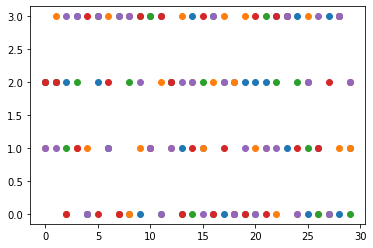

In [19]:
for i in range(5):
    route_list = utility_df.Routes_taken.to_list()[i]
    plt.scatter(range(30), route_list)